In [19]:
# -*- coding: utf-8 -*-
# Create time: 2025-09-25
# Update time: 2025-11-15

# conda activate benchmark
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams['svg.fonttype'] = 'none'

# cm 转 inch
cm_to_inch = 1 / 2.54

def plot_probing_scores_as_lineplot(dataset_configs, target = 'batch', metric='f1_score', figsize=(10, 6), save_dir=None):
    """
    以折线图风格绘制 probing 结果（仅使用batch数据）
    
    Parameters:
    -----------
    dataset_configs : list of dict
        数据集配置列表，每个字典包含：
        - 'batch_csv': batch分类结果CSV文件路径
        - 'title': 数据集标题
    metric : str
        指标名称 ('accuracy' 或 'f1_score')
    figsize : tuple
        图像大小
    save_dir : str, optional
        图片保存目录
    """
    
    # 定义模型分类
    traditional_methods = ['PCA', 'Harmony', 'Scanorama', 'scVI']
    foundation_models = ['scCello', 'Nicheformer', 'scGPT', 'CellPLM', 'GeneCompass', 'scFoundation', 'Geneformer', 'UCE']
    
    # 定义颜色
    model_colors = {
        'Harmony': '#FF8E53', 
        'PCA': '#26C281',
        'Scanorama': '#FF6B6B',
        'scVI': '#4ECDC4',
        'UCE': '#FFA502',
        'Geneformer': '#2F3542',
        'CellPLM': '#FF4757',        
        'scGPT': '#45B7D1',
        'scFoundation': '#3742FA',
        'Nicheformer': '#A4B0BE',
        'scCello': "#DB45F9",
        'GeneCompass': "#B9CF0F",
    }
    
    # 定义形状
    shapes = {
        'Traditional methods': 'o',
        'Foundation models': 's'
    }

    # 定义折线形状
    line_styles = {
        'Traditional methods': '-',
        'Foundation models': '--'
    }

    # 全局字体设置
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7

    # 提取每个数据集的batch分数
    all_scores = {}
    all_models = set()
    dataset_names = []
    
    for config in dataset_configs:
        dataset_name = config['title']
        dataset_names.append(dataset_name)
        
        # 读取数据
        df = pd.read_csv(config['csv'])

        # 提取overall的mean结果
        overall = df[
            (df['dataset'] == 'overall') &
            (df['fold'] == 'mean')
        ][['model_name', metric]].copy()

        for _, row in overall.iterrows():
            model_name = row['model_name']
            if model_name not in all_scores:
                all_scores[model_name] = []
            all_scores[model_name].append(row[metric])
            all_models.add(model_name)
    
    # 设置图像
    plt.figure(figsize=figsize)
    
    # 为每个模型绘制折线
    for model in all_models:
        # 确定模型类别
        if model in traditional_methods:
            shape = shapes['Traditional methods']
            linestyle = line_styles['Traditional methods']
        elif model in foundation_models:
            shape = shapes['Foundation models'] 
            linestyle = line_styles['Foundation models']
        else:
            shape = 'o'
            linestyle = '-'
        
        # 获取颜色
        color = model_colors.get(model, '#999999')
        
        # 绘制折线
        plt.plot(dataset_names, all_scores[model], 
                marker=shape, 
                color=color, 
                label=model,
                linestyle=linestyle,
                linewidth=1,
                alpha=0.9,
                markersize=5,
                markeredgewidth=0.1,
                markeredgecolor='white')
    
    # 设置坐标轴范围
    plt.ylim(0.08, 1.03)
    # 设置y轴刻度间隔
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0])

    # 设置图像属性
    plt.xlabel('Dataset (batch source)', fontsize=7)
    metric_name = 'Accuracy' if metric == 'accuracy' else 'F1 Score'
    target_name = 'Batch' if target == 'batch' else 'Cell Type'
    plt.ylabel(f'{target_name} Classification {metric_name}', fontsize=7)
    plt.title('')
    
    # # x轴标签倾斜
    # plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # 设置网格
    plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
    
    plt.tick_params(axis='both', which='major', labelsize=6, pad=1)

    # 设置图例
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # 分别创建两个图例
    from matplotlib.patches import Patch
    
    # Traditional methods 图例
    traditional_elements = []
    for model in traditional_methods:
        if model in labels:
            idx = labels.index(model)
            traditional_elements.append(handles[idx])
    
    # Foundation models 图例
    foundation_elements = []
    for model in foundation_models:
        if model in labels:
            idx = labels.index(model)
            foundation_elements.append(handles[idx])
    
    # 添加第一个图例（Traditional methods）
    legend1 = plt.legend(traditional_elements,
              [f'  {model}' for model in traditional_methods if model in labels],
              title='Traditional methods',
              bbox_to_anchor=(1.05, 0.75), 
              loc='center left',
              fontsize=6,
              title_fontsize=7,
            #   handletextpad=0.2,
              labelspacing=0.2,
              frameon=False,
              fancybox=False,
              shadow=False)
    
    # 添加第二个图例（Foundation models）
    legend2 = plt.legend(foundation_elements,
              [f'  {model}' for model in foundation_models if model in labels],
              title='Foundation models',
              bbox_to_anchor=(1.05, 0.2), 
              loc='center left',
              fontsize=6,
              title_fontsize=7,
            #   handletextpad=0.2,
              labelspacing=0.2,
              frameon=False,
              fancybox=False,
              shadow=False)
    
    # 需要重新添加第一个图例（因为第二个图例会覆盖）
    plt.gca().add_artist(legend1)

    # 移除上方和右方框线
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    
    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"Figure2C_probing_{target}_{metric}_lineplot.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f"Figure2C_probing_{target}_{metric}_lineplot.svg"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f"Figure2C_probing_{target}_{metric}_lineplot.jpg"), dpi=600, bbox_inches="tight")

    plt.show()



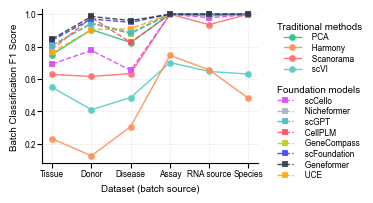

In [20]:
dataset_configs = [
    {
        'csv': "/home/wanglinting/scFM/Result/Immune/probing/batch/cv_results_summary.csv", 
        # 'title': 'Immune (tissue)',
        'title': 'Tissue',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/liver/probing/batch/cv_results_summary.csv",
        # 'title': 'Liver (donor)',
        'title': 'Donor',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_disease/probing/batch/cv_results_summary.csv",
        # 'title': 'HLCA (disease)',
        'title': 'Disease',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_sn/probing/batch/cv_results_summary.csv",
        # 'title': 'HLCA (assay)',
        'title': 'Assay',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_assay/probing/batch/cv_results_summary.csv",
        # 'title': 'HLCA (RNA source)',
        'title': 'RNA source',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/limb/probing/batch/cv_results_summary.csv",
        # 'title': 'Limb (species)',
        'title': 'Species',
    },
]


plot_probing_scores_as_lineplot(
    dataset_configs,
    target = 'batch',
    metric='f1_score', 
    figsize=(9.6 * cm_to_inch, 5.2 * cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure"
)

In [ ]:

def plot_probing_scores_as_lineplot(dataset_configs, target = 'batch', metric='f1_score', figsize=(10, 6), save_dir=None):
    """
    以折线图风格绘制 probing 结果（仅使用batch数据）
    
    Parameters:
    -----------
    dataset_configs : list of dict
        数据集配置列表，每个字典包含：
        - 'batch_csv': batch分类结果CSV文件路径
        - 'title': 数据集标题
    metric : str
        指标名称 ('accuracy' 或 'f1_score')
    figsize : tuple
        图像大小
    save_dir : str, optional
        图片保存目录
    """
    
    # 定义模型分类
    traditional_methods = ['PCA', 'Harmony', 'Scanorama', 'scVI']
    foundation_models = ['scCello', 'Nicheformer', 'scGPT', 'CellPLM', 'GeneCompass', 'scFoundation', 'Geneformer', 'UCE']
    
    # 定义颜色
    model_colors = {
        'Harmony': '#FF8E53', 
        'PCA': '#26C281',
        'Scanorama': '#FF6B6B',
        'scVI': '#4ECDC4',
        'UCE': '#FFA502',
        'Geneformer': '#2F3542',
        'CellPLM': '#FF4757',        
        'scGPT': '#45B7D1',
        'scFoundation': '#3742FA',
        'Nicheformer': '#A4B0BE',
        'scCello': "#DB45F9",
        'GeneCompass': "#B9CF0F",
    }
    
    # 定义形状
    shapes = {
        'Traditional methods': 'o',
        'Foundation models': 's'
    }

    # 定义折线形状
    line_styles = {
        'Traditional methods': '-',
        'Foundation models': '--'
    }

    # 全局字体设置
    mpl.rcParams['font.family'] = 'Arial'
    mpl.rcParams['font.size'] = 7

    # 提取每个数据集的batch分数
    all_scores = {}
    all_models = set()
    dataset_names = []
    
    for config in dataset_configs:
        dataset_name = config['title']
        dataset_names.append(dataset_name)
        
        # 读取数据
        df = pd.read_csv(config['csv'])

        # 提取overall的mean结果
        overall = df[
            (df['dataset'] == 'overall') &
            (df['fold'] == 'mean')
        ][['model_name', metric]].copy()

        for _, row in overall.iterrows():
            model_name = row['model_name']
            if model_name not in all_scores:
                all_scores[model_name] = []
            all_scores[model_name].append(row[metric])
            all_models.add(model_name)
    
    # 设置图像
    plt.figure(figsize=figsize)
    
    # 为每个模型绘制折线
    for model in all_models:
        # 确定模型类别
        if model in traditional_methods:
            shape = shapes['Traditional methods']
            linestyle = line_styles['Traditional methods']
        elif model in foundation_models:
            shape = shapes['Foundation models'] 
            linestyle = line_styles['Foundation models']
        else:
            shape = 'o'
            linestyle = '-'
        
        # 获取颜色
        color = model_colors.get(model, '#999999')
        
        # 绘制折线
        plt.plot(dataset_names, all_scores[model], 
                marker=shape, 
                color=color, 
                label=model,
                linestyle=linestyle,
                linewidth=0.75,
                alpha=0.9,
                markersize=4,
                markeredgewidth=0.1,
                markeredgecolor='white')
    
    # 设置坐标轴范围
    plt.ylim(0, 1.1)

    # 设置图像属性
    plt.xlabel('Dataset (batch source)', fontsize=7)
    metric_name = 'Accuracy' if metric == 'accuracy' else 'F1 Score'
    target_name = 'Batch' if target == 'batch' else 'Cell Type'
    plt.ylabel(f'{target_name} Classification {metric_name}', fontsize=7)
    plt.title('')
    
    # # x轴标签倾斜
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor')

    # 设置网格
    plt.grid(True, alpha=0.3, linestyle='--')
    
    plt.tick_params(axis='both', which='major', labelsize=6, pad=1)

    # 设置图例
    handles, labels = plt.gca().get_legend_handles_labels()
    
    # 分别创建两个图例
    from matplotlib.patches import Patch
    
    # Traditional methods 图例
    traditional_elements = []
    for model in traditional_methods:
        if model in labels:
            idx = labels.index(model)
            traditional_elements.append(handles[idx])
    
    # Foundation models 图例
    foundation_elements = []
    for model in foundation_models:
        if model in labels:
            idx = labels.index(model)
            foundation_elements.append(handles[idx])
    
    # 添加第一个图例（Traditional methods）
    legend1 = plt.legend(traditional_elements,
              [f'  {model}' for model in traditional_methods if model in labels],
              title='Traditional methods',
              bbox_to_anchor=(1.05, 0.7), 
              loc='center left',
              fontsize=6,
              title_fontsize=7,
            #   handletextpad=0.2,
              labelspacing=0.2,
              frameon=False,
              fancybox=False,
              shadow=False)
    
    # 添加第二个图例（Foundation models）
    legend2 = plt.legend(foundation_elements,
              [f'  {model}' for model in foundation_models if model in labels],
              title='Foundation models',
              bbox_to_anchor=(1.05, 0.1), 
              loc='center left',
              fontsize=6,
              title_fontsize=7,
            #   handletextpad=0.2,
              labelspacing=0.2,
              frameon=False,
              fancybox=False,
              shadow=False)
    
    # 需要重新添加第一个图例（因为第二个图例会覆盖）
    plt.gca().add_artist(legend1)

    # 移除上方和右方框线
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    
    # 保存图像
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, f"FigureS7_probing_{target}_{metric}_lineplot.pdf"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f"FigureS7_probing_{target}_{metric}_lineplot.svg"), bbox_inches="tight")
        plt.savefig(os.path.join(save_dir, f"FigureS7_probing_{target}_{metric}_lineplot.jpg"), dpi=600, bbox_inches="tight")

    plt.show()



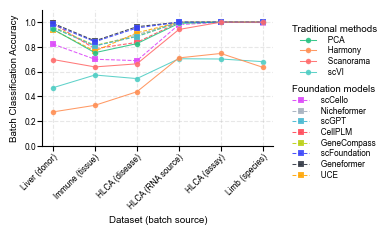

In [7]:
dataset_configs = [
    {
        'csv': "/home/wanglinting/scFM/Result/liver/probing/batch/cv_results_summary.csv",
        'title': 'Liver (donor)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/Immune/probing/batch/cv_results_summary.csv", 
        'title': 'Immune (tissue)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_disease/probing/batch/cv_results_summary.csv",
        'title': 'HLCA (disease)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_assay/probing/batch/cv_results_summary.csv",
        'title': 'HLCA (RNA source)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_sn/probing/batch/cv_results_summary.csv",
        'title': 'HLCA (assay)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/limb/probing/batch/cv_results_summary.csv",
        'title': 'Limb (species)',
    },
]


plot_probing_scores_as_lineplot(
    dataset_configs,
    target = 'batch',
    metric='accuracy', 
    figsize=(10 * cm_to_inch, 6 * cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)

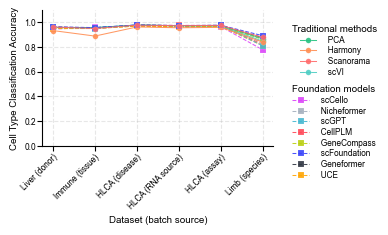

In [5]:
dataset_configs = [
    {
        'csv': "/home/wanglinting/scFM/Result/liver/probing/celltype/cv_results_summary.csv",
        'title': 'Liver (donor)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/Immune/probing/celltype/cv_results_summary.csv", 
        'title': 'Immune (tissue)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_disease/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (disease)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_assay/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (RNA source)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_sn/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (assay)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/limb/probing/celltype/cv_results_summary.csv",
        'title': 'Limb (species)',
    },
]


plot_probing_scores_as_lineplot(
    dataset_configs,
    target='celltype',
    metric='accuracy', 
    figsize=(10 * cm_to_inch, 6 * cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)

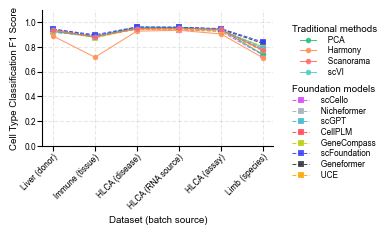

In [6]:
dataset_configs = [
    {
        'csv': "/home/wanglinting/scFM/Result/liver/probing/celltype/cv_results_summary.csv",
        'title': 'Liver (donor)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/Immune/probing/celltype/cv_results_summary.csv", 
        'title': 'Immune (tissue)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_disease/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (disease)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_assay/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (RNA source)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/HLCA_sn/probing/celltype/cv_results_summary.csv",
        'title': 'HLCA (assay)',
    },
    {
        'csv': "/home/wanglinting/scFM/Result/limb/probing/celltype/cv_results_summary.csv",
        'title': 'Limb (species)',
    },
]


plot_probing_scores_as_lineplot(
    dataset_configs,
    target='celltype',
    metric='f1_score', 
    figsize=(10 * cm_to_inch, 6 * cm_to_inch),
    save_dir="/home/wanglinting/scFM/Result/figure/probing"
)